# Fitting a 3D Bounding Box using a Differentiable Renderer

Differentiable rendering enables optimization of 3D object properties like the geometry of a mesh. Unlike traditional rendering, differentiable rendering can backpropagate gradients from image space to 3D geometry.

In this tutorial we fit a 3D bounding box around an object given ground truth images of the object. We assume images come with a segmentation mask of the object of interest and include camera extrinsics. During fitting we optimize a 3D bounding box to fit tightly around the object, despite never seeing any 3D ground truth data.

We leverage kaolin's rendering capabilities with meshes, particularly the DIB-R rasterizer in `kaolin.render.mesh.dibr_rasterization` ([API documentation](https://kaolin.readthedocs.io/en/latest/modules/kaolin.render.mesh.html)). Please note this notebook is intended to illustrate key kaolin functionality and is not intended for use in a production system. A more sophisticated use of differentiable rendering can be found in the [Optimizing a mesh using a Differentiable Renderer notebook](examples/tutorial/dibr_tutorial.ipynb). Additional DIB-R examples can be found in [this repository](https://github.com/nv-tlabs/DIB-R-Single-Image-3D-Reconstruction).

Before starting the tutorial uncompress the training data found in [examples/samples/rendered_clock.zip](examples/samples/rendered_clock.zip).

In [1]:
!pip install -q matplotlib
%matplotlib notebook

import glob
import os
from pathlib import Path
from typing import List, Tuple

import matplotlib.animation as animation
import numpy as np
import torch
from torch import Tensor
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

import kaolin

In [2]:
# set hyperparameters
batch_size_hyper = 2
mask_weight_hyper = 1.0
mask_occupancy_hyper = 0.05
mask_overlap_hyper = 1.0
lr = 5e-2
scheduler_step_size = 5
scheduler_gamma = 0.5
num_epoch = 30

# Preparing training data

First we prepare the training 2D image data and differentiable 3D bounding box mesh.

## Generating training data

Our training data consists of segmentation masks of objects with known camera properties. One way to generate this data is to use the Data Generator in the [Omniverse Kaolin App](https://docs.omniverse.nvidia.com/app_kaolin/app_kaolin/user_manual.html#data-generator). We provide sample output from the app in `examples/samples/`.

## Parsing synthetic data

We first need to parse the synthetic data generated by the Omniverse app.
The app produces one output file for each category of data - among depth map, RGB image, or segmentation map - along with an additional metadata JSON file. The JSON file includes the camera_properties, with data related to the camera settings including "clipping_range", "horizontal_aperture", "focal_length", "tf_mat".

Below we parse this training data using the `kaolin.io.render.import_synthetic_view` function.

In [3]:
# set dataset of renders and the 3D bounding box mesh
rendered_path = Path("../samples/rendered_clock/")

# prepare the 2D render dataset including camera extrinsics:
num_views = len(glob.glob(os.path.join(rendered_path, "*_rgb.png")))
train_data = []
for i in range(num_views):
    data = kaolin.io.render.import_synthetic_view(rendered_path, i, rgb=True, semantic=True)
    train_data.append(data)
dataloader = DataLoader(train_data, batch_size=batch_size_hyper, shuffle=True, pin_memory=True)

## Defining the 3D bounding box

We will use a differentiable renderer to create 2D renders of a mesh, specifically for a 3D bounding box. In 3D bounding box estimation our goal is to fit the 3D box around an object while keeping the box as some cuboid. To enforce this constraint we will take a fixed 3D cuboid and apply transformations that rotate, translate, or scale the box. Note that this constrains learning by preventing and shearing or other transformations that would deform the cuboid shape.

We create this model by loading a 3D cube mesh (provided for this tutorial in [examples/samples/bbox.obj](examples/samples/bbox.obj)) and defining a set of learnable parameters for the object rotation, translation, and scaling. When we access the vertices of the object we apply those transforms and return the modified cuboid.

In [4]:
class DifferentiableBBox:
    """Represents a differentiable 3D bounding box.

    Box is parametrized in terms of a fixed mesh and a learned (optimized)
    transformation in terms of rotation, scaling, and translation.
    """

    def __init__(self):
        """Construct a 3D bounding from a mesh filepath.

        Args:
            mesh_file (str): Filepath to load the mesh. OBJ format.
        """
        super().__init__()
        mesh_file = Path("../samples/bbox.obj")
        assert mesh_file.exists(), f"File missing: {mesh_file.absolute()}."
        

        self._mesh = kaolin.io.obj.import_mesh(mesh_file, with_materials=True)
        self._vertices = None
        self._faces = None
        
        # define the learnable parameters
        self._centers = torch.zeros((3,), dtype=torch.float, device="cuda", requires_grad=True)
        self._scales = torch.ones((3,), dtype=torch.float, device="cuda", requires_grad=True)
        self._rotations = torch.tensor([0.0, 0.0, 0.0, 1.0], device="cuda", requires_grad=True)  # rotations as quaternion
        
        # prepare the vertices for learning
        self._preprocess()

    def _preprocess(self):
        # scale up vertices to roughly the image scale
        self._vertices = self._mesh.vertices.cuda().unsqueeze(0) * 0.75
        
        # disable gradient propagation to the vertices to fix the baseline 3D bounding box
        self._vertices.requires_grad = False
        
        self._faces = self._mesh.faces.cuda()

    @property
    def vertices(self):
        # convert the rotation quaternion to a 3x3 rotation matrix (see below)
        rot = quaternion_to_matrix33(self._rotations)
        # apply scaling, rotation, and translation to vertices
        return (torch.matmul(self._vertices, rot) * self._scales) + self._centers

    @property
    def faces(self):
        return self._faces
    
    @property
    def parameters(self):
        return [self._centers, self._scales, self._rotations]

### Mesh Rotation

The mesh parameters represent the rotation as a quaternion. The image data represents points a 3D vectors, so for convenience we define a helper function that converts the quaternion rotation representation into a 3D rotation matrix. This simplifies the mesh rotation operation to a matrix multiplication.

(As an alternative you could also modify the `vertices` property of `DifferentiableBBox` to rotate the vertices using the quaternion directly.)

In [5]:
# helper functions to convert from quaternion to rotation matrix
def vector_normalize(vec: Tensor) -> Tensor:
    """Normalize a 1d vector using the L2 norm.

    Args:
        vec (Tensor): A 1d vector of shape (b,1).

    Returns:
        Tensor: A normalized version of the input vector of shape (b,1).
    """    
    return vec / vec.norm(p=2, dim=-1, keepdim=True)


def quaternion_to_matrix33(quat: Tensor) -> Tensor:
    """Convert a quaternion to a 3x3 rotation matrix.

    Args:
        quat (Tensor): Rotation quaternion of shape (4).

    Returns:
        Tensor: Rotation matrix of shape (3,3).
    """    
    # reference: http://www.euclideanspace.com/maths/geometry/rotations/conversions/quaternionToMatrix/index.htm
    q = vector_normalize(quat)
    
    qx, qy, qz, qw = q[0], q[1], q[2], q[3]
    sqw = qw ** 2
    sqx = qx ** 2
    sqy = qy ** 2
    sqz = qz ** 2
    qxy = qx * qy
    qzw = qz * qw
    qxz = qx * qz
    qyw = qy * qw
    qyz = qy * qz
    qxw = qx * qw

    invs = 1 / (sqx + sqy + sqz + sqw)
    m00 = (sqx - sqy - sqz + sqw) * invs
    m11 = (-sqx + sqy - sqz + sqw) * invs
    m22 = (-sqx - sqy + sqz + sqw) * invs
    m10 = 2.0 * (qxy + qzw) * invs
    m01 = 2.0 * (qxy - qzw) * invs
    m20 = 2.0 * (qxz - qyw) * invs
    m02 = 2.0 * (qxz + qyw) * invs
    m21 = 2.0 * (qyz + qxw) * invs
    m12 = 2.0 * (qyz - qxw) * invs
    r0 = torch.stack([m00, m01, m02])
    r1 = torch.stack([m10, m11, m12])
    r2 = torch.stack([m20, m21, m22])
    mat33 = torch.stack([r0, r1, r2]).T
    return mat33

# Setting up the fitting loop

In this section we set up the optimization and losses for training.

## Setting up the optimizer

Below we create the 3D bounding box and prepare an optimizer to tune the box's parameters. We add a learning rate scheduler so that we can gradually decrease the step size of changes made to the box parameters during the fitting process.

In [6]:
# set up model & optimization parameters
bbox = DifferentiableBBox()
optim = torch.optim.Adam(params=bbox.parameters, lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=scheduler_step_size, gamma=scheduler_gamma)

## Differentiable rendering

During training we want to optimize the 3D bounding box to overlap with the semantic segmentation mask of the object in the 2D renders. We first need to project the 3D mesh into the 2D image space for each image. The function below uses ground truth data on the camera properties to project the 3D mesh vertices onto a 2D image to produce a 2D silhouette of the mesh.

In [7]:
def project_to_2d(
    bbox: DifferentiableBBox,
    batch_size: int,
    image_shape: Tuple[int, int],
    camera_transform: Tensor,
    camera_projection: Tensor,
) -> Tensor:
    """Render a mesh onto a 2D image given a viewing camera's transform and projection.

    Args:
        bbox (DifferentiableBBox): Differentiable bounding box representing 3D mesh.
        batch_size (int): Number of elements in the data batch.
        image_shape (Tuple[int, int]): Tuple of image dimensions (height, width).
        camera_transform (Tensor): Camera transform of shape (b, 4, 3).
        camera_projection (Tensor): Camera projection of shape (b, 3, 1).

    Returns:
        Tensor: Soft mask for mesh silhouette of shape (b, h, w). (h, w) given by `image_shape`.
    """
    (face_vertices_camera, face_vertices_image, face_normals,) = kaolin.render.mesh.prepare_vertices(
        bbox.vertices.repeat(batch_size, 1, 1),
        bbox.faces,
        camera_projection,
        camera_transform=camera_transform,
    )

    nb_faces = bbox.faces.shape[0]
    face_attributes = [torch.ones((batch_size, nb_faces, 3, 1), device="cuda")]

    image_features, soft_mask, face_idx = kaolin.render.mesh.dibr_rasterization(
        image_shape[0],
        image_shape[1],
        face_vertices_camera[:, :, :, -1],
        face_vertices_image,
        face_attributes,
        face_normals[:, :, -1],
    )
    return soft_mask  # only aligning images by 2D silhouette


## Defining losses

Assuming that we have a 2D mask of the mesh in the image and the ground truth segmentation mask for that same image we can compare them. We define two losses to encourage the mesh to fit around the target object tightly:
1. `overlap` is a loss that encourages the two masks to overlap as much as possible.
2. `occupany` is a loss that encourages the 2D projection mask to be as large as possible.

With overlap alone the projection will not stay outside the shape: it's better to cut off a few corners of the object in exchange for slightly less penalty from the empty space that's saved. Adding occupany counter-balances this effect. The end result is the mesh will try to fit around the outside of the shape (convex hull).

In [8]:
def overlap(lhs_mask: Tensor, rhs_mask: Tensor) -> Tensor:
    """Compute the overlap of two 2D masks as the intersection over union.

    Args:
        lhs_mask (Tensor): 2D mask of shape (b, h, w).
        rhs_mask (Tensor): 2D mask of shape (b, h, w).

    Returns:
        Tensor: Fraction of overlap of the two masks of shape (1). Averaged over batch samples.
    """    
    batch_size, height, width = lhs_mask.shape
    assert rhs_mask.shape == lhs_mask.shape
    sil_mul = lhs_mask * rhs_mask
    sil_area = torch.sum(sil_mul.reshape(batch_size, -1), dim=1)

    return 1 - torch.mean(sil_area / (height * width))


def occupancy(mask: Tensor) -> Tensor:
    """Compute what fraction of a total image is occupied by a 2D mask.

    Args:
        mask (Tensor): 2D mask of shape (b, h, w).

    Returns:
        Tensor: Fraction of the full image occupied by the mask of shape (1). Averaged over batch samples.
    """    
    batch_size, height, width = mask.shape
    mask_area = torch.sum(mask.reshape(batch_size, -1), dim=1)
    return torch.mean(mask_area / (height * width))

## Visualization utilities

During training it's helpful to watch the progression of bounding box fitting. Below we define helper functions to plot images that show the bounding box silhouette compared to the ground truth silhouette.

In [9]:
def draw_image(gt_mask: Tensor, pred_mask: Tensor) -> np.ndarray:
    """Compute an image array showing ground truth vs predicted masks.

    Args:
        gt_mask (Tensor): Ground truth mask of shape (w, h).
        pred_mask (Tensor): Predicted mask of shape (w, h).

    Returns:
        np.ndarray: [0,1] normalized numpy array of shape (w, h, 3).
    """    
    # mask shape is [w,h]
    canvas = np.zeros((gt_mask.shape[0], gt_mask.shape[1], 3))
    canvas[..., 2] = pred_mask.cpu().detach().numpy()
    canvas[..., 1] = gt_mask.cpu().detach().numpy()

    return np.clip(canvas, 0.0, 1.0)


def show_renders(bbox: DifferentiableBBox, dataset: Tensor) -> List[np.ndarray]:
    """Generate images comparing ground truth and predicted semantic segmentations for a given mesh.

    The mesh is projected to 2D to match the camera views of each ground truth 2D render.
    Images plot the true silhouette of the object overlayed with the mesh silhouette.

    Args:
        bbox (DifferentiableBBox): Differentiable bounding box representing 3D mesh.
        dataset (Tensor): Batch of ground truth 2D renders with camera extrinsics.

    Returns:
        List[np.ndarray]: [0,1] normalized images comparing ground truth and mesh silhouette.
    """    
    with torch.no_grad():
        images = []
        for sample in dataset:
            gt_mask = sample["semantic"].cuda()
            camera_transform = sample["metadata"]["cam_transform"].cuda()
            camera_projection = sample["metadata"]["cam_proj"].cuda()

            # project model mesh onto 2D image
            img_shape = (gt_mask.shape[0], gt_mask.shape[1])
            soft_mask = project_to_2d(
                bbox,
                batch_size=1,
                image_shape=img_shape,
                camera_transform=camera_transform,
                camera_projection=camera_projection,
            )
            image = draw_image(gt_mask.squeeze(), soft_mask)
            images.append(image)

        return images

# Fitting

The fitting loop below pulls everything together. Each iteration samples a batch of ground truth 2D renders and their associated camera data. The mesh is projected to the same 2D images based on the camera properties and the projected mesh silhouette is compared to the ground truth silhouette (segmentation mask). Losses are calculated by comparing the two silhouettes and a gradient step backpropagates the error through the mesh parameters (that is, the bounding box rotation, translation, and scaling from the initial mesh position).

<IPython.core.display.Javascript object>


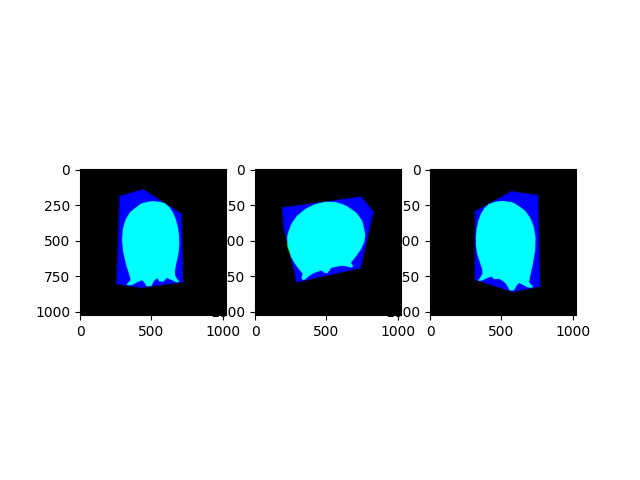

loss on epoch 0: 0.8552350401878357
loss on epoch 1: 0.7911083698272705
loss on epoch 2: 0.843265175819397
loss on epoch 3: 0.8024864792823792
loss on epoch 4: 0.8015126585960388
loss on epoch 5: 0.8122121095657349
loss on epoch 6: 0.8435664772987366
loss on epoch 7: 0.8799467086791992
loss on epoch 8: 0.843990683555603
loss on epoch 9: 0.8033567667007446
loss on epoch 10: 0.8104957938194275
loss on epoch 11: 0.7995963096618652
loss on epoch 12: 0.8065803050994873
loss on epoch 13: 0.8056159615516663
loss on epoch 14: 0.8804636597633362
loss on epoch 15: 0.8678677082061768
loss on epoch 16: 0.8349247574806213
loss on epoch 17: 0.8490930199623108
loss on epoch 18: 0.8269585371017456
loss on epoch 19: 0.8512636423110962
loss on epoch 20: 0.8039021492004395
loss on epoch 21: 0.8325901627540588
loss on epoch 22: 0.887930154800415
loss on epoch 23: 0.81057208776474
loss on epoch 24: 0.8003749847412109


In [ ]:
# set up for plotting progress during training
test_batch_ids = [2, 5, 10]  # pick canonical test render views
num_subplots = len(test_batch_ids)
fig, ax = plt.subplots(ncols=num_subplots)

# run fitting loop
image_list = []
for epoch in range(num_epoch):
    for idx, data in enumerate(dataloader):
        optim.zero_grad()  # zero out gradients for new batch

        # get image mask and camera extrinsics from the true 2D renders
        gt_mask = data["semantic"].cuda()
        camera_transform = data["metadata"]["cam_transform"].cuda()
        camera_projection = data["metadata"]["cam_proj"].cuda()

        # project the 3D mesh (bbox) onto a canvas matching the ground truth shape
        # and using the ground truth camera
        img_shape = (gt_mask.shape[1], gt_mask.shape[2])
        soft_mask = project_to_2d(
            bbox,
            batch_size=batch_size_hyper,
            image_shape=img_shape,
            camera_transform=camera_transform,
            camera_projection=camera_projection,
        )

        # compute loss by rewarding overlap with the 2D render silhouette
        # and rewarding masks that are bigger
        #   mask_overlap = reward more overlap
        mask_overlap = overlap(soft_mask, gt_mask.squeeze(-1))
        #   mask_occupancy = reward larger masks
        mask_occupancy = occupancy(soft_mask)
        
        loss = mask_occupancy * mask_occupancy_hyper + mask_overlap * mask_overlap_hyper

        # propagate losses
        loss.backward()
        optim.step()

        # view training progress
        if idx % 10 == 0:            
            test_viz = [train_data[idx] for idx in test_batch_ids]
            # only keep 1 in 10 renders to reduce animation processing time
            image_list.append(show_renders(bbox, test_viz))
            for i in range(num_subplots):
                ax[i].clear()
                ax[i].imshow(image_list[-1][i])
            fig.canvas.draw()

    # step the learning rate schedule each epoch
    # reduces the size of changes to the bbox parameters to fine-tune in later stages of fitting
    scheduler.step()
    print(f"loss on epoch {epoch:<}: {loss}")

## Animation

The code below can be used to compile the renders generated into an animation to view later (ex: when debugging learning after the fact).

In [ ]:
# generate an animation of the training loop
num_subplots = len(test_batch_ids)
fig, ax = plt.subplots(ncols=num_subplots)
ims = []
for i in range(len(image_list)):
    sp_ims = []
    for j in range(num_subplots):
        im = ax[j].imshow(image_list[i][j], animated=True)
        sp_ims.append(im)
    # show first to not have blinking animation
    if i == 0:
        for j in range(num_subplots):
            ax[j].imshow(image_list[i][j])
    ims.append(sp_ims)
ani = animation.ArtistAnimation(fig, ims, interval=60, blit=True, repeat_delay=100)
fig.show()

In [ ]:
ani.save("animation.gif", writer=animation.PillowWriter())  # optionally save the animation